Multi-fidelity prediction of molecular optical peaks with deep learning

DOI: 10.1039/D1SC05677H (Edge Article) Chem. Sci., 2022, 13, 1152-1162

https://pubs.rsc.org/en/content/articlehtml/2022/sc/d1sc05677h

# Brief background to UV-Vis Spectroscopy

**Resources:**

1. https://www.agilent.com/cs/library/primers/public/primer-uv-vis-basics-5980-1397en-agilent.pdf

2. https://www2.chemistry.msu.edu/faculty/reusch/virttxtjml/spectrpy/uv-vis/spectrum.htm

3. https://people.bath.ac.uk/gp304/uv/UV-Vis_-_D._Ferri.pdf

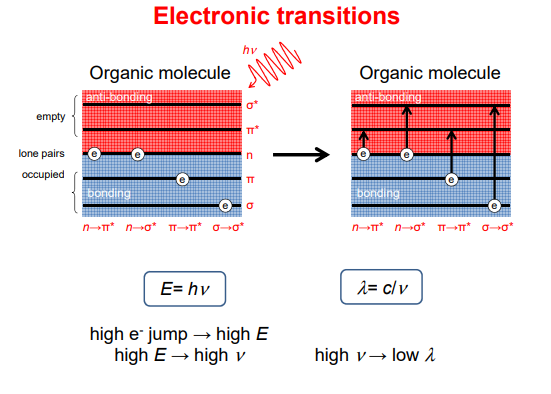

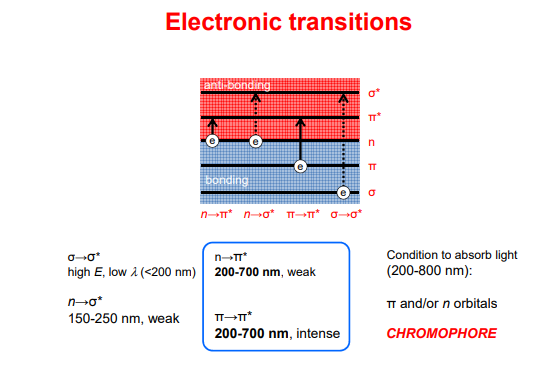

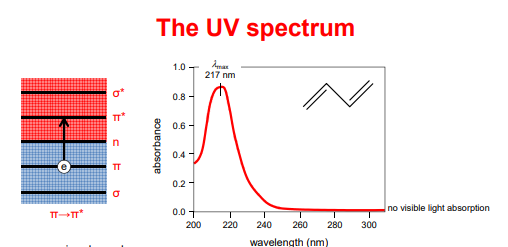

# UVvisML: Multi-fidelity prediction of molecular optical peaks with deep learning

**Reference:** Multi-fidelity prediction of molecular optical peaks with deep learning. DOI: 10.1039/D1SC05677H (Edge Article) Chem. Sci., 2022, 13, 1152-1162. https://pubs.rsc.org/en/content/articlehtml/2022/sc/d1sc05677h

## Setup

The code in this notebook uses Chemprop v1.x, which supports `python>=3.7, <3.9`. When the notebook was first published, Google Colab used a Python version that matched these requirements. As of July 2025, Google Colab uses Python 3.11, and it is challenging to make Colab run a version of Python other than its default, or to change the Colab Python kernel. As a result, this notebook includes several "hacks" to allow the code to run in Python 3.8. Most of the setup steps and the `%%py38` cell magic at the beginning of each cell can be removed if this notebook is executed locally rather than in Colab.

In [ ]:
#@title 1.1 Install modern RDKit + friends (works on Colab Py 3.12)
%time
!pip -q install "rdkit>=2024.9" "numpy>=2.0,<3" pandas pillow ipywidgets matplotlib mols2grid tqdm

# 2) Sanity check
from google.colab import output
output.enable_custom_widget_manager()

import sys, numpy as np, pandas as pd
from rdkit import rdBase, Chem
print("Python:", sys.version.split()[0])
print("NumPy :", np.__version__)
print("RDKit :", getattr(rdBase, "rdkitVersion", "unknown"))
assert Chem.MolFromSmiles("CCO")
print("RDKit import OK ✓")


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.4 MB/s eta 0:00:00
Python: 3.12.11
NumPy : 2.0.2
RDKit : 2025.03.6
RDKit import OK ✓


In [ ]:
#@title Install Python 3.8 (the maximum version supported by Chemprop 1.x) - Colab uses Python 3.11 as of July 2025
# Copied from: https://raw.githubusercontent.com/j3soon/colab-python-version/refs/heads/main/scripts/py38.sh
%%capture
!wget -O miniconda.sh https://repo.anaconda.com/miniconda/Miniconda3-py38_23.11.0-2-Linux-x86_64.sh
!bash ./miniconda.sh -b -f -p /usr/local
!conda install -q -y jupyter google-colab traitlets=5.5.0 -c conda-forge  # should take ~2 minutes
!python -m ipykernel install --name "py38" --user
!rm ./miniconda.sh

In [ ]:
!python --version # Python 3.8.18

Python 3.8.18


In [ ]:

!python3.8 -m pip install chemprop==1.7.1 numpy==1.24.4 # must specify numpy version > 1.22 to avoid C-API import error; should take ~3 minutes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.6/95.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 112.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 

In [ ]:
#@title Start a persistent Python-3.8 REPL behind the scenes to run everything in for the below cell magic
# Otherwise (with the cell magic only), variables and package imports do not carry over from cell to cell

from IPython.core.magic import register_cell_magic
from jupyter_client import KernelManager
import json, atexit, textwrap

km = KernelManager(kernel_name="python3")      # path resolves to python3.8 if on $PATH
km.kernel_cmd = ["python3.8", "-m", "ipykernel_launcher", "-f", "{connection_file}"]
km.start_kernel()

kc = km.client()
kc.start_channels()

@atexit.register
def _clean():
    kc.stop_channels()
    km.shutdown_kernel(now=True)

# Create new cell magic for cells to run their code through a Python 3.8 interpreter instead of the Colab default Python

@register_cell_magic
def py38(line, cell):
    # send code, wait for reply, print results
    msg_id = kc.execute(textwrap.dedent(cell))
    while True:
        msg = kc.get_iopub_msg()
        if msg['parent_header'].get('msg_id') == msg_id:
            if msg['msg_type'] == 'stream':
                print(msg['content']['text'], end="")
            elif msg['msg_type'] == 'error':
                print("\n".join(msg['content']['traceback']))
            elif msg['msg_type'] == 'execute_result':
                print(msg['content']['data']['text/plain'])
            elif msg['msg_type'] == 'status' and msg['content']['execution_state'] == 'idle':
                break


In [ ]:
%%py38
import chemprop # sys.path.append('/usr/local/lib/python3.8/site-packages/')

In [ ]:
!git clone https://github.com/learningmatter-mit/uvvisml

Cloning into 'uvvisml'...
remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 154 (delta 16), reused 11 (delta 9), pack-reused 123 (from 1)
Receiving objects: 100% (154/154), 9.32 MiB | 20.21 MiB/s, done.
Resolving deltas: 100% (61/61), done.


In [ ]:
%%py38
import pandas as pd
import os
os.chdir('uvvisml/uvvisml')

In [ ]:
!cd uvvisml/uvvisml; bash get_model_files.sh # may take ~2-10 minutes (download speeds from Zenodo are typically ~1-5MB/s)

--2025-09-30 13:34:31--  https://zenodo.org/record/5573027/files/models.tar.gz
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/5573027/files/models.tar.gz [following]
--2025-09-30 13:34:32--  https://zenodo.org/records/5573027/files/models.tar.gz
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 651010218 (621M) [application/octet-stream]
Saving to: ‘models.tar.gz’

models.tar.gz       100%[===================>] 620.85M   815KB/s    in 14m 16s 

2025-09-30 13:48:47 (743 KB/s) - ‘models.tar.gz’ saved [651010218/651010218]



## Data

In [ ]:
%%py38
test_file = 'data/splits/lambda_max_abs/deep4chem/group_by_smiles/smiles_target_test.csv'
df = pd.read_csv(test_file)
df

                                                 smiles  ... peakwavs_max
0                   CCN(CC)c1ccc2c(C(F)(F)F)cc(=O)oc2c1  ...        376.0
1                   CCN(CC)c1ccc2c(C(F)(F)F)cc(=O)oc2c1  ...        392.0
2                   CCN(CC)c1ccc2c(C(F)(F)F)cc(=O)oc2c1  ...        396.0
3                   CCN(CC)c1ccc2c(C(F)(F)F)cc(=O)oc2c1  ...        400.0
4                   CCN(CC)c1ccc2c(C(F)(F)F)cc(=O)oc2c1  ...        413.0
...                                                 ...  ...          ...
1705           c1cc2c3ccc[n+]4cccc(c5ccc[n+](c1)c25)c34  ...        424.0
1706           c1cc2c3ccc[n+]4cccc(c5ccc[n+](c1)c25)c34  ...        432.0
1707  COc1cc(C)c(-c2cc(-c3c(C)cc(OC)cc3C)c3ccc4c(-c5...  ...        367.0
1708  N#Cc1c(N2CCCCC2)cc(-c2cccc3ccccc23)c2c1-c1cccc...  ...        358.0
1709        N#Cc1c(N2CCCC2)cc(-c2ccccc2)c2c1Cc1ccccc1-2  ...        382.0

[1710 rows x 3 columns]


In [ ]:
!cp uvvisml/uvvisml/data/splits/lambda_max_abs/deep4chem/group_by_smiles/smiles_target_test.csv /content

In [ ]:
#@title Generate grid of your own cores from SMILES
#@markdown **Input SMILES:** Upload `.smi` files or paste SMILES (one per line).
#@markdown After you click **Generate Grid**, this will create:
#@markdown - `grid_df` (global DataFrame with a 'smiles' column)
#@markdown - `smiles_custom.csv` (Chemprop-ready input)
#@markdown - `smiles_list`, `solvent_smiles`, `test_df`, `test_file` for subsequent prediction steps.

from google.colab import files
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen, Lipinski
import mols2grid

# --- UI ---
upload_button = widgets.Button(description="Upload .smi files")
file_upload_output = widgets.Output()

smiles_textarea = widgets.Textarea(
    value="""OC[C@H]1[C@H](C2=CC(F)=CC=C2)CN(C3=CC(C)=NC=C3C#N)C1
O[C@H]1[C@H](C2=CC=CC=C2)CN(C3=CC(C)=NC=C3C#N)C1
N#CC1=CC(C)=C(CC)N=C1N2C[C@@H](CO)[C@H](C3=CC=CC=C3)C2
N#CC1=CN=CC=C1N2C[C@@H](C(OC)=O)[C@H](C3=CC(F)=CC=C3)C2
OC([C@H]1[C@H](C2=CC=CC=C2)CN(C(C)=O)C1)=O
OC([C@H]1[C@H](C2=CC=CC(OC)=C2)CN(C(C3=NC(N4C=NC=N4)=CC=C3)=O)C1)=O
OC([C@H]1[C@H](C2=CC=CC(OC)=C2)CN(C(C3=CC(OCCO4)=C4C=C3)=O)C1)=O""",
    placeholder='Paste SMILES here (one per line)',
    description='Paste SMILES:',
    layout=widgets.Layout(width='80%', height='150px')
)

solvent_smiles_input = widgets.Text(
    value="CC#N",
    placeholder='Enter solvent SMILES',
    description='Solvent SMILES:',
    layout=widgets.Layout(width='80%')
)


input_choice = widgets.ToggleButtons(
    options=['Paste SMILES', 'Upload .smi files'],
    description='Input method:',
)

generate_button = widgets.Button(description="Generate Grid and Data Files")
grid_output = widgets.Output()

# Global holder for uploaded bytes
uploaded_files_content = None

def on_upload_button_clicked(b):
    with file_upload_output:
        clear_output()
        print("Select one or more .smi files…")
        uploaded = files.upload()
        if uploaded:
            print("Files uploaded. Click 'Generate Grid and Data Files' to process.")
            global uploaded_files_content
            uploaded_files_content = uploaded
        else:
            print("No files uploaded.")

upload_button.on_click(on_upload_button_clicked)

def generate_grid_from_input(b):
    with grid_output:
        clear_output()
        global smiles_list
        smiles_list = []

        # 1) Collect SMILES from chosen source
        if input_choice.value == 'Paste SMILES':
            smiles_text = smiles_textarea.value.strip()
            if smiles_text:
                smiles_list = [line.strip() for line in smiles_text.splitlines() if line.strip()]
            else:
                print("No SMILES pasted.")
        else:
            global uploaded_files_content
            if uploaded_files_content:
                for filename, content in uploaded_files_content.items():
                    print(f"Processing file: {filename}")
                    content_string = content.decode('utf-8', errors='ignore')
                    for line in content_string.splitlines():
                        line = line.strip()
                        if not line or line.startswith('#'):
                            continue
                        # assume first token is SMILES
                        smiles_list.append(line.split(maxsplit=1)[0])
            else:
                print("No files were uploaded or selected.")

        if not smiles_list:
            print("No SMILES provided. Paste or upload, then click 'Generate Grid and Data Files'.")
            uploaded_files_content = None
            return

        print(f"Read {len(smiles_list)} SMILES.")

        # 2) Build DataFrame and validate with RDKit
        df = pd.DataFrame({"smiles": smiles_list})
        df["mol"] = df["smiles"].apply(Chem.MolFromSmiles)
        df = df[df["mol"].notna()].drop_duplicates(subset=["smiles"]).reset_index(drop=True)

        if df.empty:
            print("No valid molecules could be created from the provided SMILES.")
            uploaded_files_content = None
            return

        print(f"Valid molecules: {len(df)}.")

        # 3) Expose a minimal global for downstream steps + write Chemprop input
        global grid_df
        grid_df = df[["smiles"]].copy().reset_index(drop=True)
        smiles_custom_csv = "smiles_custom.csv"
        grid_df.to_csv(smiles_custom_csv, index=False)
        print(f"Wrote {smiles_custom_csv} with {len(grid_df)} unique SMILES.")

        # 4) Optional: lightweight descriptors for the grid view
        df["MW"]    = df["mol"].apply(Descriptors.MolWt)
        df["cLogP"] = df["mol"].apply(Crippen.MolLogP)
        df["HBA"]   = df["mol"].apply(Lipinski.NumHAcceptors)
        df["HBD"]   = df["mol"].apply(Lipinski.NumHDonors)

        grid = mols2grid.display(
            df,
            smiles_col="smiles",
            mol_col="mol",
            subset=["img", "MW", "cLogP", "HBA", "HBD", "smiles"],
            transform={
                "MW":    lambda x: f"MW {round(x,1)}",
                "cLogP": lambda x: f"logP {x:.2f}",
                "HBA":   lambda x: f"HBA {x}",
                "HBD":   lambda x: f"HBD {x}",
            },
            use_svg=True,
            n_cols=4
        )
        display(grid)

        # 5) Create UVVisML experimental test file from your SMILES + a single solvent
        global solvent_smiles
        solvent_smiles = solvent_smiles_input.value.strip()
        if not solvent_smiles:
            print("Please enter a solvent SMILES.")
            uploaded_files_content = None
            return

        global test_df
        test_df = pd.DataFrame({"smiles": smiles_list, "solvent": solvent_smiles})
        global test_file
        test_file = "/content/my_expt_test.csv"
        test_df.to_csv(test_file, index=False)
        print(test_df.head(3), f"\nWrote {test_file}")

        uploaded_files_content = None  # reset after success

generate_grid_from_input(None)  # (optional) auto-run once to materialize defaults
generate_button.on_click(generate_grid_from_input)

# Show UI
display(input_choice)
display(smiles_textarea, upload_button, file_upload_output)
display(solvent_smiles_input)
display(generate_button, grid_output)

ToggleButtons(description='Input method:', options=('Paste SMILES', 'Upload .smi files'), value='Paste SMILES'…

Textarea(value='OC[C@H]1[C@H](C2=CC(F)=CC=C2)CN(C3=CC(C)=NC=C3C#N)C1\nO[C@H]1[C@H](C2=CC=CC=C2)CN(C3=CC(C)=NC=…

Button(description='Upload .smi files', style=ButtonStyle())

Output()

Text(value='CC#N', description='Solvent SMILES:', layout=Layout(width='80%'), placeholder='Enter solvent SMILE…

Button(description='Generate Grid and Data Files', style=ButtonStyle())

Output()

## Make Predictions

## Predict experimental peak with model trained on combined training set

**Equivalent to command line:**

python uvvisml/predict.py --test_file uvvisml/data/splits/lambda_max_abs/deep4chem/group_by_smiles/smiles_target_test.csv --property absorption_peak_nm_expt --method chemprop --preds_file test_preds.csv

In [ ]:
#@title Predict experimental peak with model trained on combined training set
%%py38
import chemprop
import pandas as pd

# ✅ Use your exact file (must have columns: smiles, solvent)
test_file = "/content/my_expt_test.csv"

# Read the SAME file you'll predict on, so row counts line up
df = pd.read_csv(test_file)

arguments = [
  '--test_path', test_file,
  '--preds_path', '/dev/null',  # keep preds in Python; no CSV written by chemprop
  '--checkpoint_dir', 'models/lambda_max_abs/chemprop/combined/production/fold_0',
  '--number_of_molecules', '2',
  # '--gpu', '0',
]

args = chemprop.args.PredictArgs().parse_args(arguments)
preds = chemprop.train.make_predictions(args=args)

# First task (λmax) per row
preds = [x[0] for x in preds]

# Attach to the SAME df we predicted on
df['peakwavs_max_pred'] = preds

# (Optional) save both full table and a compact solute-only table
df.to_csv('preds_with_inputs.csv', index=False)
if 'smiles' in df.columns:
    df[['smiles','peakwavs_max_pred']].drop_duplicates('smiles').to_csv('custom_uvvis_predictions.csv', index=False)

df.head()


Loading training args
/usr/local/lib/python3.8/site-packages/chemprop/utils.py:472: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vars(torch.load(path, map_location=lambda s

In [ ]:
#@title Save the DataFrame with predictions to a CSV file
%%py38
df.to_csv('/content/Predictions - Model 1.csv', index=False)
print("Predictions saved to /content/Predictions - Model 1.csv")

Predictions saved to /content/Predictions - Model 1.csv


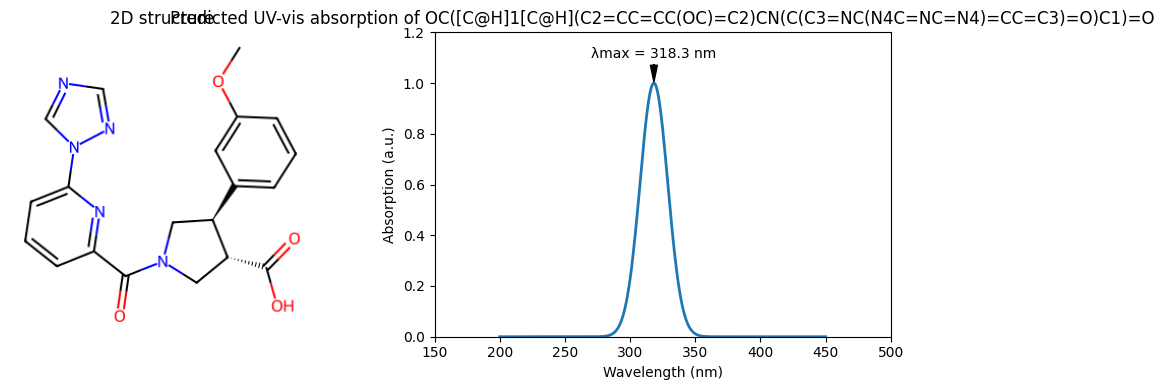

In [ ]:
#@title Simulated UV–vis spectrum
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

csv_path = Path("Predictions - Model 1.csv")
df = pd.read_csv(csv_path)

# ---- Row 2 (index 1)
row = df.iloc[5]
smiles = str(row.get("smiles", ""))
if not smiles:
    raise ValueError("No 'smiles' column or empty value in row 2.")

# ==========================
# 2D depiction (PNG)
# ==========================
mol = Chem.MolFromSmiles(smiles)
if mol is None:
    raise ValueError(f"Could not parse SMILES: {smiles}")
AllChem.Compute2DCoords(mol)

# Draw molecule as PNG (RDKit → PIL image)
mol_img = Draw.MolToImage(mol, size=(300, 300))

# ==========================
# Simulated UV–vis spectrum
# ==========================
def parse_peaks(val):
    if pd.isna(val):
        return []
    if isinstance(val, (int, float, np.floating)):
        return [float(val)]
    s = str(val).strip().strip("[]()")
    parts = [p for p in s.replace(";", ",").split(",") if p.strip()]
    peaks = []
    for p in parts:
        try:
            peaks.append(float(p))
        except ValueError:
            pass
    return peaks

# Prefer predicted peaks; fall back to experimental
peaks = parse_peaks(row.get("peakwavs_max_pred", np.nan)) or \
        parse_peaks(row.get("peakwavs_max", np.nan))
if not peaks:
    raise ValueError("No peak wavelengths found in row 2.")

wave_min, wave_max, step = 200, 450, 1
waves = np.arange(wave_min, wave_max + step, step)

fwhm = 25.0
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))

def gaussian(x, mu, s):
    return np.exp(-0.5 * ((x - mu) / s) ** 2)

y = np.zeros_like(waves, dtype=float)
for mu in peaks:
    y += gaussian(waves, mu, sigma)
if y.max() > 0:
    y /= y.max()

# ==========================
# Display molecule + spectrum together
# ==========================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4)) # Original figure size

# Molecule PNG
ax1.imshow(mol_img)
ax1.axis("off")
ax1.set_title("2D structure")

# UV-vis plot
ax2.plot(waves, y, linewidth=2)
ax2.set_xlabel("Wavelength (nm)")
ax2.set_ylabel("Absorption (a.u.)")
ax2.set_xlim(150, 500) # Increased x-axis limits
ax2.set_ylim(0, 1.2) # Adjusted y-axis limit
ax2.set_title(f"Predicted UV-vis absorption of {smiles}") # Updated title

# Add peak annotation
if peaks:
    peak_wavelength = peaks[0] # Assuming the first peak is the main one
    ax2.annotate(f"λmax = {peak_wavelength:.1f} nm",
                 xy=(peak_wavelength, max(y)),
                 xytext=(peak_wavelength, max(y) + 0.1), # Adjusted annotation position to be slightly above peak
                 ha='center',
                 arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5))


plt.tight_layout()
plt.show()

## Predict TDDFT peak in vacuum

**Equivalent to command line:**

python uvvisml/predict.py --test_file uvvisml/data/splits/lambda_max_abs/deep4chem/group_by_smiles/smiles_target_test.csv --property vertical_excitation_eV_tddft --method chemprop --preds_file test_preds.csv

In [ ]:
%%py38
arguments = [
  '--test_path', test_file,
  '--preds_path', '/dev/null',
  '--checkpoint_dir', 'models/lambda_max_abs_wb97xd3/chemprop/all_wb97xd3/production/fold_0',
  '--number_of_molecules', '1',
  #'--gpu', '0'
]

args = chemprop.args.PredictArgs().parse_args(arguments)
preds = chemprop.train.make_predictions(args=args)

preds = [x[0] for x in preds] # predictions are in eV
df['peakwavs_max_pred'] = preds
df['peakwavs_max_pred'] = 1240/df['peakwavs_max_pred'] # convert from eV to nm
df

In [ ]:
%%py38
df.to_csv('/content/Predictions - Model:TDDFT peak in vacuum.csv', index=False)
print("Predictions saved to /content/Predictions - Model:TDDFT peak in vacuum.csv")

Predictions saved to /content/Predictions - Model:TDDFT peak in vacuum.csv


In [ ]:
#@title Simulated UV–vis spectrum (TDDFT)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Assuming the TDDFT prediction results are in the 'df' variable from the previous cell (kswx6y_uJHqW)

# ---- Row 2 (index 1)
row = df.iloc[0] # Changed from 1 to 0
smiles = str(row.get("smiles", ""))
if not smiles:
    raise ValueError("No 'smiles' column or empty value in row 2.")

# ==========================
# 2D depiction (PNG)
# ==========================
mol = Chem.MolFromSmiles(smiles)
if mol is None:
    raise ValueError(f"Could not parse SMILES: {smiles}")
AllChem.Compute2DCoords(mol)

# Draw molecule as PNG (RDKit → PIL image)
mol_img = Draw.MolToImage(mol, size=(300, 300))

# ==========================
# Simulated UV–vis spectrum
# ==========================
def parse_peaks(val):
    if pd.isna(val):
        return []
    if isinstance(val, (int, float, np.floating)):
        return [float(val)]
    s = str(val).strip().strip("[]()")
    parts = [p for p in s.replace(";", ",").split(",") if p.strip()]
    peaks = []
    for p in parts:
        try:
            peaks.append(float(p))
        except ValueError:
            pass
    return peaks

# Use predicted peaks from the TDDFT model
peaks = parse_peaks(row.get("peakwavs_max_pred", np.nan))
if not peaks:
    raise ValueError("No peak wavelengths found in row 2 for TDDFT predictions.")

wave_min, wave_max, step = 200, 450, 1
waves = np.arange(wave_min, wave_max + step, step)

fwhm = 25.0
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))

def gaussian(x, mu, s):
    return np.exp(-0.5 * ((x - mu) / s) ** 2)

y = np.zeros_like(waves, dtype=float)
for mu in peaks:
    y += gaussian(waves, mu, sigma)
if y.max() > 0:
    y /= y.max()

# ==========================
# Display molecule + spectrum together
# ==========================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4)) # Original figure size

# Molecule PNG
ax1.imshow(mol_img)
ax1.axis("off")
ax1.set_title("2D structure", fontsize=10) # Reduced fontsize

# UV-vis plot
ax2.plot(waves, y, linewidth=2)
ax2.set_xlabel("Wavelength (nm)")
ax2.set_ylabel("Absorption (a.u.)")
ax2.set_xlim(150, 500) # Increased x-axis limits
ax2.set_ylim(0, 1.2) # Adjusted y-axis limit
ax2.set_title(f"Predicted TDDFT UV-vis absorption of {smiles}", fontsize=10) # Reduced fontsize

# Add peak annotation
if peaks:
    peak_wavelength = peaks[0] # Assuming the first peak is the main one
    ax2.annotate(f"λmax = {peak_wavelength:.1f} nm",
                 xy=(peak_wavelength, max(y)),
                 xytext=(peak_wavelength, max(y) + 0.1), # Adjusted annotation position to be slightly above peak
                 ha='center',
                 arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5))


plt.tight_layout(pad=4.0) # Keeping the increased padding

plt.show()

## Predict experimental peak with model trained on Deep4Chem training set

**Equivalent to command line:**

python uvvisml/predict.py --test_file uvvisml/data/splits/lambda_max_abs/deep4chem/group_by_smiles/smiles_target_test.csv --property absorption_peak_nm_expt --method chemprop --preds_file test_preds.csv --train_dataset deep4chem

In [ ]:
#@title Predict experimental peak with model trained on Deep4Chem training set
%%py38
arguments = [
  '--test_path', test_file,
  '--preds_path', '/dev/null',
  '--checkpoint_dir', 'models/lambda_max_abs/chemprop/deep4chem/production/fold_0',
  '--number_of_molecules', '2',
  #'--gpu', '0'
]

args = chemprop.args.PredictArgs().parse_args(arguments)
preds = chemprop.train.make_predictions(args=args)

preds = [x[0] for x in preds]
df['peakwavs_max_pred'] = preds
df

UsageError: Cell magic `%%py38` not found.


In [ ]:
%%py38
df.to_csv('/content/Predictions - Model: trained on Deep4Chem training set.csv', index=False)
print("Predictions saved to /content/Predictions - Model: trained on Deep4Chem training set.csv")

Predictions saved to /content/Predictions - Model: trained on Deep4Chem training set.csv


## Predict experimental peak with multi-fidelity model

**Equivalent to command line:**

python uvvisml/predict.py --test_file uvvisml/data/splits/lambda_max_abs/deep4chem/group_by_smiles/smiles_target_test.csv --property absorption_peak_nm_expt --method chemprop_tddft --preds_file test_preds.csv

In [ ]:
%%py38
# TDDFT Predictions
arguments = [
  '--test_path', test_file,
  '--preds_path', 'test_tddft_preds.csv',
  '--checkpoint_dir', 'models/lambda_max_abs_wb97xd3/chemprop/all_wb97xd3/production/fold_0',
  '--number_of_molecules', '1',
  #'--gpu', '0'
]

args = chemprop.args.PredictArgs().parse_args(arguments)
_ = chemprop.train.make_predictions(args=args)

# Convert Predictions to Features File
!python models/tddft_to_features_file.py

# Experimental Predictions
arguments = [
  '--test_path', test_file,
  '--preds_path', '/dev/null',
  '--checkpoint_dir', 'models/lambda_max_abs/chemprop_tddft/combined/production/fold_0',
  '--number_of_molecules', '2',
  '--features_path', 'features_test.csv'
  #'--gpu', '0'
]

args = chemprop.args.PredictArgs().parse_args(arguments)
preds = chemprop.train.make_predictions(args=args)

preds = [x[0] for x in preds]
df['peakwavs_max_pred'] = preds
df

Loading training args
/usr/local/lib/python3.8/site-packages/chemprop/utils.py:472: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vars(torch.load(path, map_location=lambda s

## Predict experimental peak with model trained on combined training set (with ensemble variance)

**Equivalent to command line:**

python uvvisml/predict.py --test_file uvvisml/data/splits/lambda_max_abs/deep4chem/group_by_smiles/smiles_target_test.csv --property absorption_peak_nm_expt --method chemprop --preds_file test_preds.csv

In [ ]:
%%py38
arguments = [
  '--test_path', test_file,
  '--preds_path', 'test_preds.csv',
  '--checkpoint_dir', 'models/lambda_max_abs/chemprop/combined/production/fold_0',
  '--number_of_molecules', '2',
  '--ensemble_variance',
  #'--gpu', '0'
]

args = chemprop.args.PredictArgs().parse_args(arguments)
_ = chemprop.train.make_predictions(args=args)

df = pd.read_csv('test_preds.csv')
df

Loading training args
/usr/local/lib/python3.8/site-packages/chemprop/utils.py:472: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vars(torch.load(path, map_location=lambda s

#UVvis-MPNN - message passing neural network

Machine Learning odels for Predicting Molecular UV−Vis Spectra with Quantum Mechanical Properties https://pubs.acs.org/action/showCitFormats?doi=10.1021/acs.jcim.2c01662&ref=pdf

https://github.com/PNNL-CompBio/ML_UVvisModels

In [ ]:
# @title 1) Install packages (Py3.12/NumPy 2.x friendly)
!pip -q install "rdkit>=2024.9" "numpy>=2.0,<3" pandas scikit-learn matplotlib tqdm
# Torch is usually preinstalled in Colab. If not, install a CPU wheel:
import importlib, sys
try:
    import torch
    print("Found torch", torch.__version__)
except Exception:
    print("Installing CPU-only torch (works fine for quick tests)...")
    !pip -q install torch --index-url https://download.pytorch.org/whl/cpu
    import torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 46.4 MB/s eta 0:00:00
Found torch 2.8.0+cu126


In [ ]:
# @title 2) Sanity check
from google.colab import output
output.enable_custom_widget_manager()

import sys, numpy as np, pandas as pd
import torch
from rdkit import Chem, rdBase

print("Python :", sys.version.split()[0])
print("NumPy  :", np.__version__)
print("RDKit  :", getattr(rdBase, "rdkitVersion", "unknown"))
print("Torch  :", torch.__version__, "| CUDA avail:", torch.cuda.is_available())
assert Chem.MolFromSmiles("c1ccccc1") is not None
print("✅ RDKit import OK")


Python : 3.12.11
NumPy  : 2.0.2
RDKit  : 2025.03.6
Torch  : 2.8.0+cu126 | CUDA avail: True
✅ RDKit import OK


In [ ]:
# @title 3) Clone PNNL UVvis-MPNN (for data + reference)
!rm -rf /content/ML_UVvisModels
!git clone -q --depth 1 https://github.com/PNNL-CompBio/ML_UVvisModels.git /content/ML_UVvisModels
!ls -lah /content/ML_UVvisModels/UVvis-MPNN || true


total 36K
drwxr-xr-x 6 root root 4.0K Oct  3 14:00 .
drwxr-xr-x 8 root root 4.0K Oct  3 14:00 ..
drwxr-xr-x 4 root root 4.0K Oct  3 14:00 3D_distance_plus_spectra
drwxr-xr-x 4 root root 4.0K Oct  3 14:00 3D_only
drwxr-xr-x 3 root root 4.0K Oct  3 14:00 original
drwxr-xr-x 4 root root 4.0K Oct  3 14:00 original_plus_spectra
-rw-r--r-- 1 root root 4.2K Oct  3 14:00 README.md
-rw-r--r-- 1 root root  526 Oct  3 14:00 spectra_scaling.py


In [ ]:
# 0) Pull LFS objects (models/data not fetched by a shallow clone)
!apt-get -y -qq install git-lfs
!git -C /content/ML_UVvisModels lfs install
!git -C /content/ML_UVvisModels lfs pull

# Show what's now available
!printf "\nModel files found:\n"; \
  find /content/ML_UVvisModels -maxdepth 5 -type f -name "model.pt" -print
!printf "\nCandidate CSVs:\n"; \
  find /content/ML_UVvisModels/UVvis-MPNN -maxdepth 5 -type f -name "*.csv" -print


Updated git hooks.
Git LFS initialized.

Model files found:
/content/ML_UVvisModels/UVvis-MPNN/3D_only/models_3D_only/model_1/model.pt
/content/ML_UVvisModels/UVvis-MPNN/3D_only/models_3D_only/model_8/model.pt
/content/ML_UVvisModels/UVvis-MPNN/3D_only/models_3D_only/model_2/model.pt
/content/ML_UVvisModels/UVvis-MPNN/3D_only/models_3D_only/model_6/model.pt
/content/ML_UVvisModels/UVvis-MPNN/3D_only/models_3D_only/model_5/model.pt
/content/ML_UVvisModels/UVvis-MPNN/3D_only/models_3D_only/model_9/model.pt
/content/ML_UVvisModels/UVvis-MPNN/3D_only/models_3D_only/model_4/model.pt
/content/ML_UVvisModels/UVvis-MPNN/3D_only/models_3D_only/model_0/model.pt
/content/ML_UVvisModels/UVvis-MPNN/3D_only/models_3D_only/model_3/model.pt
/content/ML_UVvisModels/UVvis-MPNN/3D_only/models_3D_only/model_7/model.pt
/content/ML_UVvisModels/UVvis-MPNN/3D_distance_plus_spectra/models_3D_distance_plus_spectra/model_1/model.pt
/content/ML_UVvisModels/UVvis-MPNN/3D_distance_plus_spectra/models_3D_distance_pl

In [ ]:
%%bash
set -e

# Install Miniforge (conda) once
if [ ! -d "/usr/local/conda" ]; then
  wget -q https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh -O /tmp/miniforge.sh
  bash /tmp/miniforge.sh -b -p /usr/local/conda
fi

# Create a dedicated env with Python 3.8 (works with chemprop 1.7.1)
# RDKit 2022.09.5 is available for Py3.8 on conda-forge
/usr/local/conda/bin/conda create -y -n uvvis38 -c conda-forge python=3.8 rdkit=2022.09.5

# Install chemprop 1.7.1 + a pandas version that supports Py3.8
/usr/local/conda/bin/conda run -n uvvis38 python -m pip -q install chemprop==1.7.1 pandas==1.5.3

# Quick sanity check
/usr/local/conda/bin/conda run -n uvvis38 python - <<'PY'
import chemprop, sys
print("Chemprop:", chemprop.__version__, "| Python:", sys.version.split()[0])
PY

echo "✅ Env ready. Use: /usr/local/conda/bin/conda run -n uvvis38 <command>"


Channels:
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local/conda/envs/uvvis38

  added / updated specs:
    - python=3.8
    - rdkit=2022.09.5


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    boost-1.78.0               |   py38hae673b5_5         311 KB  conda-forge
    certifi-2024.8.30          |     pyhd8ed1ab_0         160 KB  conda-forge
    chardet-5.2.0              |   py38h578d9bd_1         219 KB  conda-forge
    contourpy-1.1.1            |   py38h7f3f72f_1         217 KB  conda-forge
    cycler-0.12.1              |     pyhd8ed1ab_0          13 KB  conda-forge
    fonttools-4.53.1           |   py38h2019614_0         2.2 MB  conda-forge
    greenlet-3.0.3             |   py38h17151c0_0         205 KB  conda-forge
    importlib-resources-6.4.5  |     pyhd8ed1ab_0           9 KB  conda-forge
    im



==> WARNING: A newer version of conda exists. <==
    current version: 25.3.1
    latest version: 25.9.0

Please update conda by running

    $ conda update -n base -c conda-forge conda




In [ ]:
# @title 4) Load dataset and detect wavelength columns
import glob, re, pandas as pd, numpy as np, os

DATA_DIR = "/content/ML_UVvisModels/UVvis-MPNN"
cands = glob.glob(f"{DATA_DIR}/**/*.csv", recursive=True) + glob.glob(f"{DATA_DIR}/*.csv")
print("Found CSVs:", [os.path.basename(x) for x in cands])

def pick_csv(pathlist):
    for p in pathlist:
        try:
            df = pd.read_csv(p)
            cols = [c.lower() for c in df.columns]
            if any("smile" in c for c in cols) and len(df.columns) > 50:
                return p, df
        except Exception:
            pass
    return None, None

csv_path, df = pick_csv(cands)
assert csv_path is not None, "No usable CSV found. Tell me the file you want to use."
print("Using:", os.path.basename(csv_path))

# Normalize columns
df = df.dropna().drop_duplicates()
smi_col = next(c for c in df.columns if "smile" in c.lower())

# Find wavelength columns by pulling numbers from column names (e.g., wl_200, lambda_300)
def extract_nm(col):
    m = re.findall(r'(\d+\.?\d*)', col)
    if not m: return None
    try:
        v = float(m[-1])
        return v if 150 <= v <= 1000 else None
    except:
        return None

wl_cols = []
for c in df.columns:
    if c == smi_col: continue
    nm = extract_nm(c)
    if nm is not None:
        wl_cols.append((c, nm))

if len(wl_cols) < 50:
    # fallback: assume all non-SMILES numeric cols are spectrum; make a synthetic wavelength axis
    numeric_cols = [c for c in df.columns if c != smi_col and np.issubdtype(df[c].dtype, np.number)]
    wl_cols = [(c, i) for i, c in enumerate(numeric_cols)]
    print("⚠️ Could not parse nm from column names. Using index as wavelength axis.")

# sort by wavelength ascending
wl_cols = sorted(wl_cols, key=lambda x: x[1])
COLS, WL = zip(*wl_cols)
WL = np.array(WL, dtype=float)

print(f"SMILES column: {smi_col} | spectrum bins: {len(COLS)}")
df = df[[smi_col] + list(COLS)]


Found CSVs: ['rmse_mae.csv']


AssertionError: No usable CSV found. Tell me the file you want to use.